In [1]:
########################################
# Packages + global performance settings
########################################

using LinearAlgebra
using Optim
using ForwardDiff
using Plots
using Printf
using FiniteDiff
using Statistics

# Small constants / safety floors
const KD_FLOOR = 1e-4
const KS_FLOOR = 0.0

# For speed in notebooks: avoid accidental global-variable penalties by putting
# everything in functions and using typed structs (we do that below).


0.0

In [2]:
#################################
# Parameters + initial conditions
#################################

struct Params
    # Time/grid
    Δt::Float64
    T::Int

    # Preferences
    ρ::Float64
    η::Float64

    # Growth & depreciation
    δ::Float64
    gL::Float64
    gA::Float64

    # Production primitives
    α::Float64
    σf::Float64
    σ0::Float64
    θd::Float64
    ϑc::Float64
    ξ::Float64

    # Production derived (used downstream)
    εf::Float64
    ε0::Float64
    θc::Float64
    ϕd::Float64
    ϕc::Float64
    ϕE::Float64
    ϕf::Float64

    # Adjustment / stranding
    χ::Float64
    χs::Float64
    vareps::Float64
    vareps2::Float64

    # Damages / climate
    ζ::Float64
    γ::Float64

    # Emissions intensity ψ(·)
    ψ1::Float64
    ψ2::Float64
    ψ3::Float64
    gψ::Float64
    Kd0_agg::Float64

    # Tech change / learning
    gσ::Float64
    ω::Float64
    M0::Float64
    ϱ::Float64
    PBAU::Float64

    # Exogenous initial levels
    L0::Float64
    A0::Float64

    # Initial state (effective-labour units)
    kf0::Float64
    kd0::Float64
    kc0::Float64
    ks0::Float64
    T0::Float64
    S0::Float64
end

# Centralized derivations (one source of truth)
function derive_production(σf, σ0, θd, ϑc)
    εf = (σf - 1) / σf
    ε0 = (σ0 - 1) / σ0
    θc = θd * ϑc / (1 - ϑc)

    ϕd = 1 / ((θc / θd)^(1 - ε0) + 1)
    ϕc = 1 - ϕd

    ϕE = 1 / (1 + (ϕc * θc^ε0 + ϕd * θd^ε0)^(εf/ε0 - 1) * ϕc * θc^(ε0 - 1))
    ϕf = 1 - ϕE

    return εf, ε0, θc, ϕd, ϕc, ϕE, ϕf
end

function default_params(; T::Int=201)
    # Time/grid
    Δt = 1.0

    # Preferences
    ρ = 0.011
    η = 1.35

    # Growth & depreciation
    δ  = 0.04
    gL = 0.0029
    gA = 0.02

    # Production primitives
    α  = 0.3
    σf = 0.2
    σ0 = 2.0
    θd = 0.1777
    ϑc = 0.16
    ξ  = 0.01

    εf, ε0, θc, ϕd, ϕc, ϕE, ϕf = derive_production(σf, σ0, θd, ϑc)

    # Adjustment / stranding
    χ   = 1.0
    χs  = 5.0
    vareps   = 300.0
    vareps2 = 0.004

    # Damages
    ζ = 0.0006
    γ = 0.0201

    # Emissions ψ
    ψ1 = 6.265
    ψ2 = 0.77
    ψ3 = 0.795
    gψ = 0.01
    Kd0_agg = 56.7042

    # Tech change / learning
    gσ = 0.027
    ω  = 0.5
    M0 = 50.0
    ϱ  = 0.1
    PBAU = 53.2

    # Exogenous initial levels
    L0 = 8.16
    A0 = 9.02

    # Initial states (effective-labour units)
    kf0 = 4.39
    kd0 = kf0 * θd - ξ
    kc0 = kf0 * θc
    ks0 = 0.0
    T0  = 1.38
    S0  = T0 / ζ

    return Params(
        Δt, T,
        ρ, η,
        δ, gL, gA,
        α, σf, σ0, θd, ϑc, ξ,
        εf, ε0, θc, ϕd, ϕc, ϕE, ϕf,
        χ, χs, vareps, vareps2,
        ζ, γ,
        ψ1, ψ2, ψ3, gψ, Kd0_agg,
        gσ, ω, M0, ϱ, PBAU,
        L0, A0,
        kf0, kd0, kc0, ks0, T0, S0
    )
end


default_params (generic function with 1 method)

In [3]:
########################
# Parameter diagnostics
########################

function print_group(io::IO, title::String, pairs)
    println(io, "\n", title)
    for (k, v) in pairs
        @printf(io, "  %-10s = %.16g\n", k, v)
    end
end

function check_params(p::Params)
    io = stdout

    print_group(io, "Time/grid", [
        ("Δt", p.Δt), ("T", p.T)
    ])

    print_group(io, "Preferences", [
        ("ρ", p.ρ), ("η", p.η)
    ])

    print_group(io, "Growth & depreciation", [
        ("δ", p.δ), ("gL", p.gL), ("gA", p.gA)
    ])

    print_group(io, "Production primitives", [
        ("α", p.α), ("σf", p.σf), ("σ0", p.σ0),
        ("θd", p.θd), ("ϑc", p.ϑc), ("ξ", p.ξ)
    ])

    print_group(io, "Production derived", [
        ("εf", p.εf), ("ε0", p.ε0), ("θc", p.θc),
        ("ϕd", p.ϕd), ("ϕc", p.ϕc), ("ϕE", p.ϕE), ("ϕf", p.ϕf)
    ])

    print_group(io, "Initial state", [
        ("kf0", p.kf0), ("kd0", p.kd0), ("kc0", p.kc0),
        ("ks0", p.ks0), ("T0", p.T0), ("S0", p.S0)
    ])

    # Sanity checks
    @assert abs((p.ϕc + p.ϕd) - 1) < 1e-10 "Energy weights don't sum to 1"
    @assert abs((p.ϕf + p.ϕE) - 1) < 1e-10 "Final/E weights don't sum to 1"
    @assert p.σf != 0 && p.σ0 != 0
    @assert p.θd > 0
    @assert 0 < p.ϑc < 1

    println("\nSanity checks: OK")
    return nothing
end

p = default_params()
check_params(p)



Time/grid
  Δt         = 1
  T          = 201

Preferences
  ρ          = 0.011
  η          = 1.35

Growth & depreciation
  δ          = 0.04
  gL         = 0.0029
  gA         = 0.02

Production primitives
  α          = 0.3
  σf         = 0.2
  σ0         = 2
  θd         = 0.1777
  ϑc         = 0.16
  ξ          = 0.01

Production derived
  εf         = -4
  ε0         = 0.5
  θc         = 0.03384761904761905
  ϕd         = 0.696167565299313
  ϕc         = 0.303832434700687
  ϕE         = 4.694760681872253e-05
  ϕf         = 0.9999530523931813

Initial state
  kf0        = 4.39
  kd0        = 0.7701029999999999
  kc0        = 0.1485910476190476
  ks0        = 0
  T0         = 1.38
  S0         = 2300

Sanity checks: OK


In [4]:
#################
# Math primitives
#################

@inline function softplus(x, vareps::Float64)
    z  = vareps * x
    zv = ForwardDiff.value(z)              # safe scalar for branch decision
    return (zv > 30.0) ? x : (log1p(exp(z)) / vareps)
end

@inline function exog_LA(t::Int, p::Params)
    L = p.L0 * (1.0 + p.gL)^t
    A = p.A0 * (1.0 + p.gA)^t
    return L, A
end

@inline damage_factor(S, p::Params) = exp(-0.5 * p.γ * (p.ζ*S)^2)

@inline function epsilon_energy(t::Int, S, p::Params)
    # Keep Mratio on the AD path when it's above 1; clamp only using a value-based branch.
    Mratio_raw = (p.M0 + p.PBAU*t - S + p.S0) / p.M0
    Mratio = (ForwardDiff.value(Mratio_raw) < 1.0) ? one(Mratio_raw) : Mratio_raw

    TC = p.ω * exp(-p.gσ * t) + (1.0 - p.ω) * Mratio^(-p.ϱ)
    ε  = 1.0 - TC / p.σ0
    σ  = p.σ0 / TC
    return ε, σ, Mratio, TC
end

@inline function energy(kd, kc, ε, p::Params)
    inside = p.ϕd * (kd + p.ξ)^ε + p.ϕc * (kc)^ε
    return inside^(1/ε)
end

@inline function output_y(kf, E, Ω, p::Params)
    inside = p.ϕf * kf^(p.εf) + p.ϕE * E^(p.εf)
    return inside^(p.α/p.εf) * Ω
end

@inline function emissions_P(kd, ks, t::Int, p::Params)
    L, A = exog_LA(t, p)
    AL = A * L

    tot = kd + ks
    if ForwardDiff.value(tot) <= 0.0
        return zero(tot)
    end

    term_exp = exp(-p.ψ2 * p.Kd0_agg * (ks / tot)) - exp(-p.ψ2 * p.Kd0_agg)
    hetero   = (p.ψ1 / p.ψ2) * (tot / p.Kd0_agg) * term_exp
    linear   = p.ψ3 * kd
    intensity = exp(-p.gψ * t) * (hetero + linear)

    return AL * intensity
end

nothing

In [5]:
################################
# One-step flows and transitions
################################

struct SimResult{T}
    kd::Vector{T}
    kc::Vector{T}
    kf::Vector{T}
    ks::Vector{T}
    S::Vector{T}

    P::Vector{T}
    E::Vector{T}
    y::Vector{T}
    c::Vector{T}

    ε::Vector{T}
    σ::Vector{T}
    Mratio::Vector{T}
    TC::Vector{T}

    Ω::Vector{T}
end

# AD-safe "floor": uses value() only for the branch decision
@inline function floor_if_needed(x, floorval)
    return (ForwardDiff.value(x) < floorval) ? floorval : x
end

@inline function nonneg_if_needed(x)
    return (ForwardDiff.value(x) < 0.0) ? zero(x) : x
end

function simulate(p::Params, id, ic, iF)
    T = p.T
    @assert length(id) == T
    @assert length(ic) == T
    @assert length(iF) == T

    Tnum = promote_type(eltype(id), eltype(ic), eltype(iF), Float64)

    kd = Vector{Tnum}(undef, T+1)
    kc = Vector{Tnum}(undef, T+1)
    kf = Vector{Tnum}(undef, T+1)
    ks = Vector{Tnum}(undef, T+1)
    S  = Vector{Tnum}(undef, T+1)

    P  = Vector{Tnum}(undef, T)
    E  = Vector{Tnum}(undef, T)
    y  = Vector{Tnum}(undef, T)
    c  = Vector{Tnum}(undef, T)

    εv = Vector{Tnum}(undef, T)
    σv = Vector{Tnum}(undef, T)
    Mr = Vector{Tnum}(undef, T)
    TC = Vector{Tnum}(undef, T)

    Ω  = Vector{Tnum}(undef, T)

    kd[1] = Tnum(p.kd0)
    kc[1] = Tnum(p.kc0)
    kf[1] = Tnum(p.kf0)
    ks[1] = Tnum(p.ks0)
    S[1]  = Tnum(p.S0)

    decay_eff = p.δ + p.gL + p.gA
    decay = (1.0 - decay_eff)^(p.Δt)

    kd_floor = Tnum(KD_FLOOR)
    kc_floor = Tnum(KD_FLOOR)
    kf_floor = Tnum(KD_FLOOR)
    ks_floor = Tnum(KS_FLOOR)

    @inbounds for t in 0:(T-1)
        i = t + 1

        # Floors for denominators etc (AD-safe)
        kdi = floor_if_needed(kd[i], kd_floor)
        kci = floor_if_needed(kc[i], kc_floor)
        kfi = floor_if_needed(kf[i], kf_floor)
        ksi = floor_if_needed(ks[i], ks_floor)

        Ω[i] = damage_factor(S[i], p)

        εi, σi, Mri, TCi = epsilon_energy(t, S[i], p)
        εv[i] = Tnum(εi)
        σv[i] = Tnum(σi)
        Mr[i] = Tnum(Mri)
        TC[i] = Tnum(TCi)

        E[i] = energy(kdi, kci, εv[i], p)
        y[i] = output_y(kfi, E[i], Ω[i], p)
        P[i] = emissions_P(kdi, ksi, t, p)

        S[i+1] = S[i] + P[i] * p.Δt

        # Adjustment costs
        adj_f = p.χ * (iF[i]^2) / kfi
        adj_c = p.χ * (ic[i]^2) / kci
        adj_d = p.χ * (id[i]^2) / kdi

        # Dirty investment decomposition
        id_pos = softplus(id[i], p.vareps)

        strand_flow = softplus(-id[i] + p.vareps2, p.vareps) - p.vareps2
        strand_flow = nonneg_if_needed(strand_flow)

        negpart = softplus(-id[i], p.vareps)
        Θ = p.χs * (negpart^2) / kdi

        # Consumption
        c[i] = y[i] - iF[i] - ic[i] - id_pos - Θ

        # Capital laws of motion
        kf[i+1] = decay * kfi + iF[i]*p.Δt - adj_f*p.Δt
        kc[i+1] = decay * kci + ic[i]*p.Δt - adj_c*p.Δt

        posweight = id_pos / (id_pos + softplus(-id[i], p.vareps) + Tnum(1e-12))
        kd_next = decay * kdi + id[i]*p.Δt - posweight * adj_d * p.Δt
        kd[i+1] = floor_if_needed(kd_next, kd_floor)

        ks_next = decay * ksi + strand_flow * p.Δt
        ks[i+1] = floor_if_needed(ks_next, ks_floor)
    end

    return SimResult{Tnum}(kd, kc, kf, ks, S, P, E, y, c, εv, σv, Mr, TC, Ω)
end

nothing

In [6]:
#########
# Welfare
#########

@inline function u_crra(c, η::Float64)
    if η == 1.0
        return log(c)
    else
        return c^(1.0-η) / (1.0-η)
    end
end

function welfare_corrected(sim::SimResult{T}, p::Params) where {T}
    Tnum = eltype(sim.c)
    W = zero(Tnum)

    const_penalty = Tnum(-10.0)
    slope_penalty = Tnum(1000.0)

    r_minus_g = p.ρ - p.gL + (p.η - 1.0) * p.gA   # Parameters!B56

    @inbounds for t in 0:(p.T-1)
        c = sim.c[t+1]

        if ForwardDiff.value(c) > 0.0
            df = exp(-r_minus_g * t)              # X(t)
            per = u_crra(c, p.η) * df * p.Δt      # * Δt

            # Terminal perpetuity at final period (t = 200 when p.T = 201)
            if t == p.T - 1 && r_minus_g > 0
                per /= r_minus_g                  # / (r-g)
            end

            W += per
        else
            W += const_penalty + slope_penalty * c
        end
    end

    return W
end

nothing

In [7]:
######################
# Optimisation wrapper
######################

function unpack_controls(z::AbstractVector, p::Params)
    T = p.T
    @assert length(z) == 3*T
    id = @view z[1:T]
    ic = @view z[T+1:2T]
    iF = @view z[2T+1:3T]
    return id, ic, iF
end

function objective(z::AbstractVector, p::Params)
    id, ic, iF = unpack_controls(z, p)
    sim = simulate(p, id, ic, iF)
    return -welfare_corrected(sim, p)
end

# Build a cached ForwardDiff gradient config (much faster, fewer allocations)
function make_objgrad(p::Params, z0::AbstractVector)
    f(z) = objective(z, p)
    cfg = ForwardDiff.GradientConfig(f, z0)
    function g!(G, z)
        ForwardDiff.gradient!(G, f, z, cfg)
        return G
    end
    return f, g!
end

nothing

In [8]:
###########
# Optimiser
###########

using Random
using LineSearches

p = default_params()
T = p.T

# Bounds
id_lo, id_hi = -0.30,  1.00
ic_lo, ic_hi =  0.00,  1.00
iF_lo, iF_hi =  0.00,  2.00

lower = vcat(fill(id_lo, T), fill(ic_lo, T), fill(iF_lo, T))
upper = vcat(fill(id_hi, T), fill(ic_hi, T), fill(iF_hi, T))

marg = 1e-4

# Known-good constant start (use this for restart 1)
z_bestguess = vcat(
    fill(-0.023987197601898196, T),
    fill( 0.035933838308864034, T),
    fill( 0.2819492338130605,   T)
)
z_bestguess = clamp.(z_bestguess, lower .+ marg, upper .- marg)

# ----------------------------
# Start generators
# ----------------------------

# Simple iid jitter
function jittered_start(zbase, lower, upper; scale=0.005)
    width = upper .- lower
    z = zbase .+ scale .* width .* (2 .* rand(length(zbase)) .- 1)
    return clamp.(z, lower .+ 1e-4, upper .- 1e-4)
end

# Smooth random controls (low-frequency perturbations) to jump basins without jaggedness
function smooth_random_start(zbase, lower, upper; amp=0.15, nknots=8)
    T = length(zbase) ÷ 3
    width = upper .- lower

    function smooth_vec(T; nknots=8)
        knots = randn(nknots)
        xk = range(0, 1, length=nknots)
        xt = range(0, 1, length=T)
        # simple linear interpolation between knots
        v = similar(collect(xt))
        for i in 1:T
            x = xt[i]
            j = searchsortedlast(xk, x)
            j = clamp(j, 1, nknots-1)
            w = (x - xk[j]) / (xk[j+1] - xk[j])
            v[i] = (1-w)*knots[j] + w*knots[j+1]
        end
        # normalize to ~[-1,1]
        m = maximum(abs.(v))
        return (m > 0) ? (v ./ m) : v
    end

    id = smooth_vec(T; nknots=nknots)
    ic = smooth_vec(T; nknots=nknots)
    iF = smooth_vec(T; nknots=nknots)

    z = copy(zbase)
    z[1:T]            .+= amp .* width[1:T]            .* id
    z[T+1:2T]         .+= amp .* width[T+1:2T]         .* ic
    z[2T+1:3T]        .+= amp .* width[2T+1:3T]        .* iF

    return clamp.(z, lower .+ 1e-4, upper .- 1e-4)
end

# ----------------------------
# Penalty pieces
# ----------------------------

# Softplus that branches on VALUE (AD-safe)
@inline function softplus_plain(x, vareps::Float64=80.0)
    z = vareps * x
    zv = ForwardDiff.value(z)
    return (zv > 30.0) ? x : (log1p(exp(z)) / vareps)
end

function c_floor_penalty(sim, c_floor::Float64, λ::Float64)
    pen = zero(eltype(sim.c))
    @inbounds for ci in sim.c
        gap = softplus_plain(c_floor - ci, 80.0)   # ≈ max(c_floor-ci, 0)
        pen += gap * gap
    end
    return λ * pen
end

# ----------------------------
# One run
# ----------------------------

function run_once(p::Params, lower, upper, zstart;
                  mu0=1e-3, iters=800, showtrace=false,
                  use_penalty::Bool=true, c_floor=1.0, λ=5e4)

    T = p.T
    zstart = clamp.(zstart, lower .+ 1e-4, upper .- 1e-4)

    function f(z)
        id = view(z, 1:T)
        ic = view(z, T+1:2*T)
        iF = view(z, 2*T+1:3*T)

        sim = simulate(p, id, ic, iF)

        # reject numerical blow-ups early
        if any(x -> !isfinite(ForwardDiff.value(x)), sim.c)
            return Inf
        end

        obj = -welfare_corrected(sim, p)
        if use_penalty
            obj += c_floor_penalty(sim, c_floor, λ)
        end
        return obj
    end

    cfg = ForwardDiff.GradientConfig(f, zstart)
    function g!(G, z)
        ForwardDiff.gradient!(G, f, z, cfg)
        return G
    end


    od = OnceDifferentiable(f, g!, zstart)

    opts = Optim.Options(
        iterations = iters,
        x_reltol = 1e-9,
        g_tol = 1e-7,
        f_reltol = 1e-9,
        show_trace = showtrace,
        show_every = 10
    )

    inner = LBFGS(linesearch = LineSearches.BackTracking(order=3))
    res = optimize(od, lower, upper, zstart, Fminbox(inner; mu0=mu0), opts)
    zstar = Optim.minimizer(res)

    # Evaluate TRUE welfare (no penalty)
    id_star = collect(view(zstar, 1:T))
    ic_star = collect(view(zstar, T+1:2*T))
    iF_star = collect(view(zstar, 2*T+1:3*T))
    sim_star = simulate(p, id_star, ic_star, iF_star)

    W = welfare_corrected(sim_star, p)
    cmin = minimum(sim_star.c)

    return res, zstar, W, cmin
end

# ----------------------------
# Continuation helper
# ----------------------------

function continuation_solve(p, lower, upper, z0;
                            λs = (2e5, 5e4, 1e4, 2e3),
                            c_floor=1.0,
                            iters=1200)

    z = z0
    bestW = -Inf
    bestz = z0
    bestc = NaN
    bestres = nothing

    for (j, λ) in enumerate(λs)
        res, z, W, cmin = run_once(p, lower, upper, z;
                                   mu0 = (j==1 ? 1e-3 : 1e-6),
                                   iters = iters,
                                   showtrace = false,
                                   use_penalty = true,
                                   c_floor = c_floor,
                                   λ = λ)

        @printf("CONT %d: λ=%.1e  W=%.12f  min(c)=%.6f  converged=%s\n",
                j, λ, W, cmin, string(Optim.converged(res)))

        if W > bestW
            bestW = W; bestz = z; bestc = cmin; bestres = res
        end
    end

    return bestres, bestz, bestW, bestc
end

# ----------------------------
# MULTI-START DRIVER
# ----------------------------

Random.seed!(1)

n_local  = 20   # close to bestguess
n_global = 10   # occasional bigger / smoother jumps

bestW = -Inf
bestz = z_bestguess
bestc = NaN

# Optional warm start for sensitivity analysis:
# set z_warm = previous optimum when you have it; else leave as nothing.
z_warm = nothing

for k in 1:(n_local + n_global)
    z0 =
        if k == 1
            (z_warm === nothing) ? z_bestguess : clamp.(z_warm, lower .+ marg, upper .- marg)
        elseif k <= n_local
            jittered_start(bestz, lower, upper; scale=0.005)
        else
            # mix: half large iid jitter, half smooth random
            if isodd(k)
                jittered_start(bestz, lower, upper; scale=0.10)
            else
                smooth_random_start(bestz, lower, upper; amp=0.20, nknots=8)
            end
        end

    # Continuation (penalty schedule) from this start
    res_pen, z_pen, W_pen, cmin_pen = continuation_solve(
        p, lower, upper, z0;
        λs = (2e5, 5e4, 1e4, 2e3),
        c_floor = 1.0,
        iters = 1000
    )

    @printf("restart %2d (cont-pen): W = %.9f, min(c)=%.6g, converged=%s\n",
            k, W_pen, cmin_pen, string(res_pen === nothing ? false : Optim.converged(res_pen)))

    if W_pen > bestW
        bestW = W_pen
        bestz = z_pen
        bestc = cmin_pen
    end
end

println("\nBEST after continuation-penalty search: W = ", bestW, "   (min(c) = ", bestc, ")")

# Final POLISH (no penalty), starting from bestz
res_pol, z_pol, W_pol, cmin_pol = run_once(
    p, lower, upper, bestz;
    use_penalty = false,
    mu0 = 1e-6,
    iters = 8000,
    showtrace = false
)

@printf("POLISH (no penalty): W = %.12f   (min(c) = %.6f)  converged=%s\n",
        W_pol, cmin_pol, string(Optim.converged(res_pol)))

# Final unpack for downstream
z_star = z_pol
id_star = collect(view(z_star, 1:T))
ic_star = collect(view(z_star, T+1:2*T))
iF_star = collect(view(z_star, 2*T+1:3*T))

sim_star = simulate(p, id_star, ic_star, iF_star)
println("Optimal W (corrected) = ", welfare_corrected(sim_star, p))
nothing


CONT 1: λ=2.0e+05  W=-187.291340249643  min(c)=1.048065  converged=true
CONT 2: λ=5.0e+04  W=-187.191885756581  min(c)=1.046869  converged=true
CONT 3: λ=1.0e+04  W=-187.041480333437  min(c)=1.043568  converged=true
CONT 4: λ=2.0e+03  W=-187.003394317409  min(c)=1.039181  converged=true
restart  1 (cont-pen): W = -187.003394317, min(c)=1.03918, converged=true
CONT 1: λ=2.0e+05  W=-187.263404054314  min(c)=1.048584  converged=true
CONT 2: λ=5.0e+04  W=-187.105039011103  min(c)=1.042188  converged=true
CONT 3: λ=1.0e+04  W=-186.577418074481  min(c)=1.037671  converged=true
CONT 4: λ=2.0e+03  W=-186.348463656171  min(c)=1.028966  converged=true
restart  2 (cont-pen): W = -186.348463656, min(c)=1.02897, converged=true
CONT 1: λ=2.0e+05  W=-187.312787250201  min(c)=1.046078  converged=true
CONT 2: λ=5.0e+04  W=-186.905598803536  min(c)=1.045834  converged=true
CONT 3: λ=1.0e+04  W=-186.411055234172  min(c)=1.040058  converged=true
CONT 4: λ=2.0e+03  W=-186.168493283500  min(c)=1.033871  con

Year   t     Emissions P(t)        i_d(t)              i_c(t)
2025    0         53.19541056         -0.02837075          0.03772942
2026    1         42.47319253         -0.01090906          0.04104367
2027    2         38.98840221         -0.00635169          0.04420584
2028    3         36.39451553         -0.00444639          0.04728538
2029    4         34.15829499         -0.00343418          0.05007838
2030    5         32.14043504         -0.00298975          0.05229333
2031    6         30.27130012         -0.00306443          0.05398262
2032    7         28.50003195          0.00986032          0.05519152
2033    8         27.68333574          0.00970501          0.05685079
2034    9         26.90654745          0.00956061          0.05835503
2035   10         26.16823339          0.00942730          0.05957048
2036   11         25.46707230          0.00933193          0.06048421
2037   12         24.80361180          0.00925904          0.06111039
2038   13         24.1774388

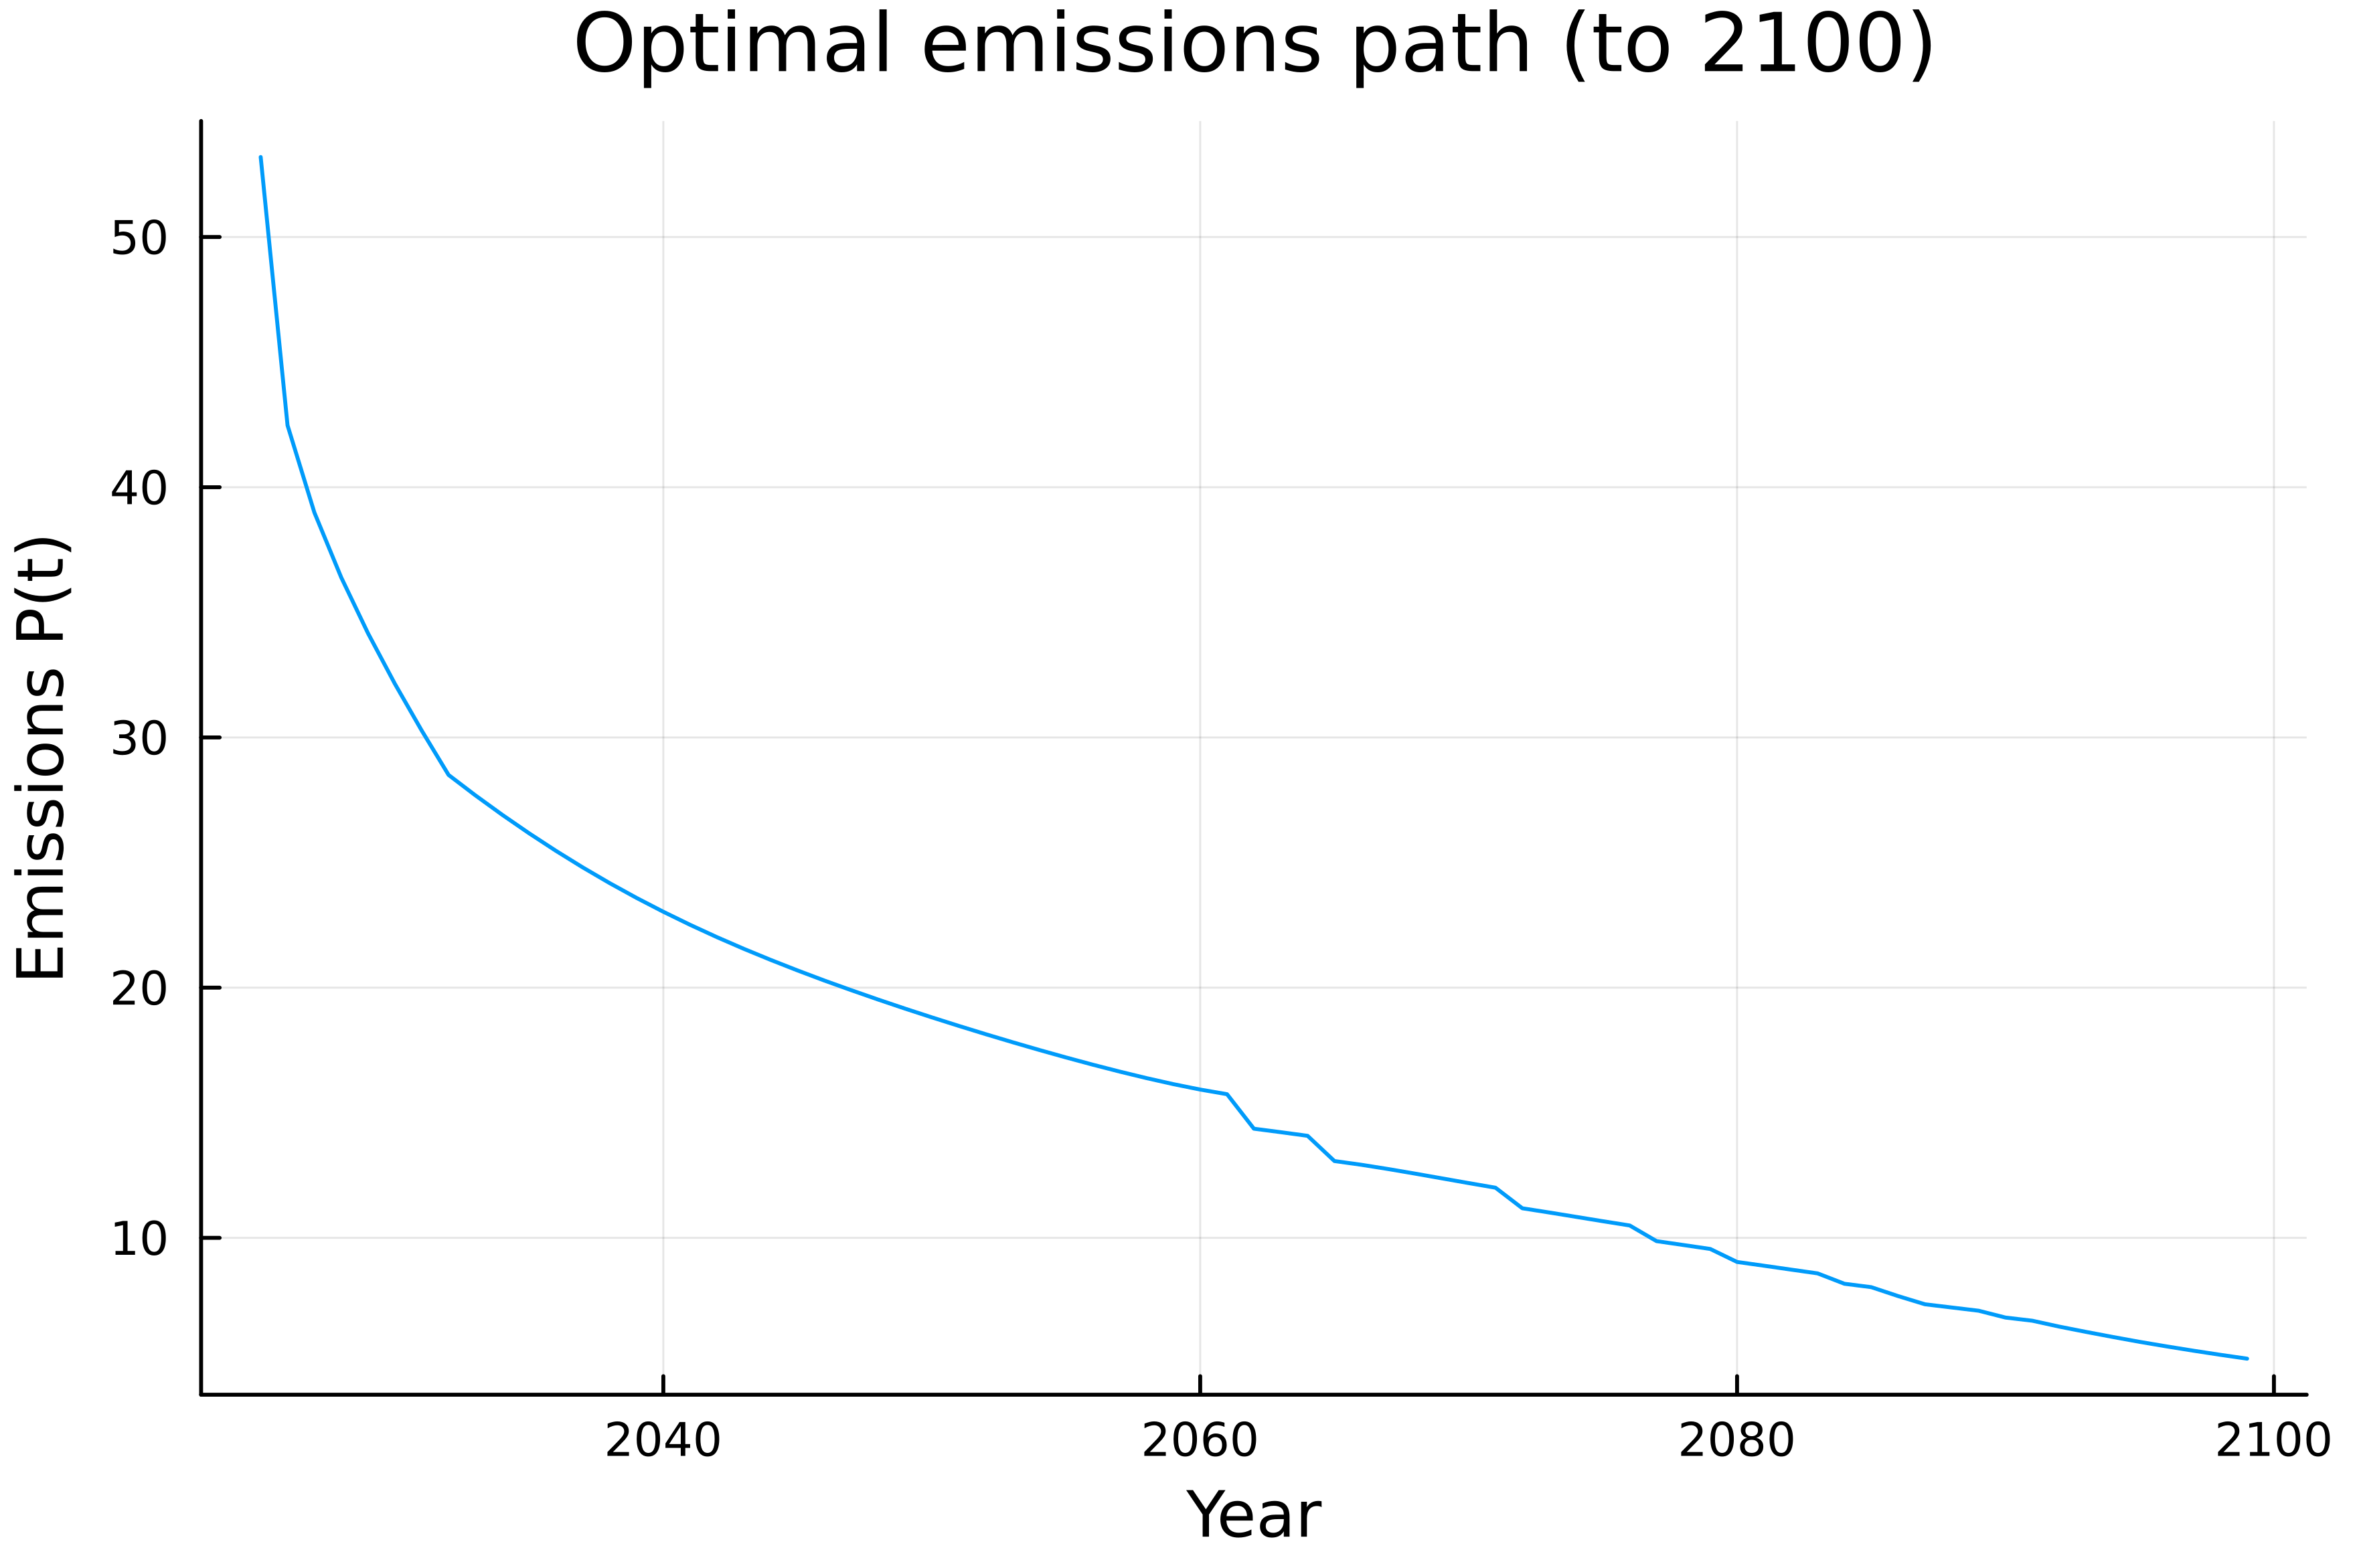

In [12]:
############################################
# Inspect + plot optimal paths to 2100 (t=0:74)
############################################

base_year = 2025          # change if needed
Tplot = min(75, p.T)

t = collect(0:(Tplot-1))
years = base_year .+ t

emissions = sim_star.P[1:Tplot]
i_d = id_star[1:Tplot]
i_c = ic_star[1:Tplot]

# ---- Print table ----
println("Year   t     Emissions P(t)        i_d(t)              i_c(t)")
for i in 1:Tplot
    @printf("%4d  %3d  %18.8f  %18.8f  %18.8f\n",
            years[i], t[i], emissions[i], i_d[i], i_c[i])
end

# ---- Summary stats ----
println("\nSummary stats (first $Tplot periods):")
@printf("Emissions: min=%g  max=%g  mean=%g\n", minimum(emissions), maximum(emissions), mean(emissions))
@printf("i_d:       min=%g  max=%g  mean=%g\n", minimum(i_d),       maximum(i_d),       mean(i_d))
@printf("i_c:       min=%g  max=%g  mean=%g\n", minimum(i_c),       maximum(i_c),       mean(i_c))

# ---- Plots ----
plot(years, emissions,
     xlabel="Year", ylabel="Emissions P(t)",
     title="Optimal emissions path (to 2100)", legend=false)

#plot(years, i_d,
     #xlabel="Year", ylabel="i_d(t)",
     #title="Optimal dirty investment control (to 2100)", legend=false)

#plot(years, i_c,
     #xlabel="Year", ylabel="i_c(t)",
     #title="Optimal clean investment control (to 2100)", legend=false)


In [10]:
############################################
# Export optimal controls to CSV for Excel
############################################

using DelimitedFiles

base_year = 2025                      # change if needed
T = p.T
t = collect(0:(T-1))
year = base_year .+ t

# Controls (optimal)
i_d = id_star
i_c = ic_star
i_f = iF_star

# Output filename
fname = "optimal_controls.csv"

# Header + data matrix
header = ["year", "t", "i_d", "i_c", "i_f"]
data = hcat(year, t, i_d, i_c, i_f)

# Write CSV
open(fname, "w") do io
    writedlm(io, header, ',')
    writedlm(io, data, ',')
end

println("Wrote: ", abspath(fname))


Wrote: c:\Users\DIETZS\Dropbox\Frank\Stranded assets\optimal_controls.csv


In [11]:
############################################################
# Export key outputs (incl. SCC) from the optimal simulation
# - Proper header row (across top)
# - Exports ks at beginning and end of each period
############################################################

using DelimitedFiles

base_year = 2026
T = p.T
t = collect(0:(T-1))
year = base_year .+ t

# Exogenous scale factors AL(t)
AL = Vector{Float64}(undef, T)
@inbounds for i in 1:T
    L, A = exog_LA(t[i], p)
    AL[i] = A * L
end

# Controls
i_d = id_star
i_c = ic_star
i_f = iF_star

# Core outputs
P    = sim_star.P[1:T]
S    = sim_star.S[1:T]
Temp = p.ζ .* S
kd = sim_star.kd[1:T]
kc = sim_star.kc[1:T]
kf = sim_star.kf[1:T]
ks = sim_star.ks[1:T]

# Aggregates
E_agg = sim_star.E[1:T] .* AL
Y_agg = sim_star.y[1:T] .* AL
C_agg = sim_star.c[1:T] .* AL

# SCC
r = p.ρ - p.gL + p.η * p.gA
time = p.Δt .* t
disc = exp.(-r .* time)
flow = disc .* Y_agg .* p.γ .* p.ζ .* Temp

SCC = Vector{Float64}(undef, T)
@inbounds for i in 1:T
    pv = sum(flow[i:end]) * p.Δt
    SCC[i] = 1000.0 * exp(r * time[i]) * pv
end

# ---- Write CSV with a true header row ----
header = [
    "year","t",
    "i_d","i_c","i_f",
    "P_emissions","Temp",
    "kd","kc","kf",
    "ks",
    "E_agg","Y_agg","C_agg",
    "SCC"
]

data = hcat(
    year, t,
    i_d, i_c, i_f,
    P, Temp,
    kd, kc, kf,
    ks,
    E_agg, Y_agg, C_agg,
    SCC
)

fname = "optimal_outputs.csv"
open(fname, "w") do io
    write(io, join(header, ",") * "\n")   # header across top
    writedlm(io, data, ',')              # numeric matrix
end

println("\nWrote: ", abspath(fname))



Wrote: c:\Users\DIETZS\Dropbox\Frank\Stranded assets\optimal_outputs.csv
